# 설명 가능한 딥러닝 실행

2025-04-27 17:57:48.986942: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 17:57:48.996486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745744269.006314    6817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745744269.009141    6817 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745744269.017125    6817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

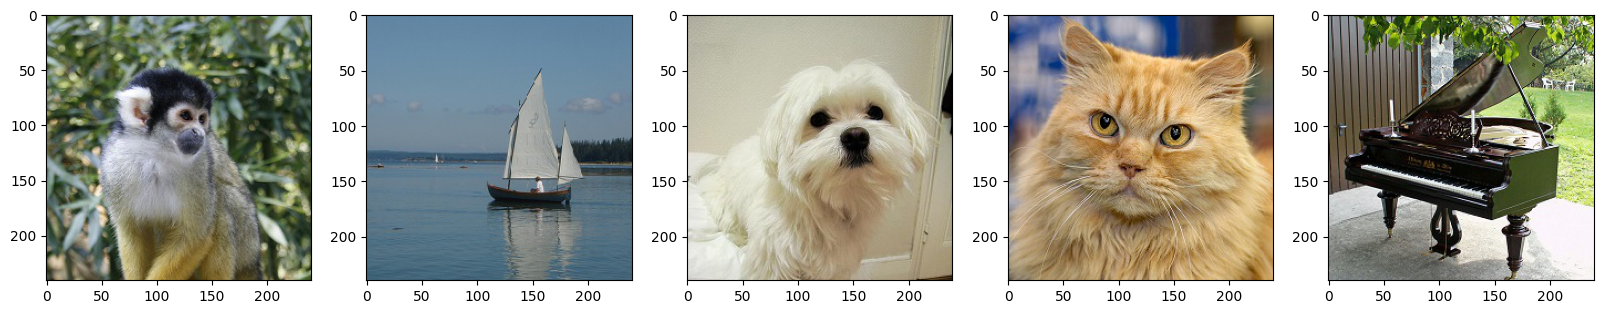

In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

# XAI 알고리즘을 로드
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# !git clone https://github.com/taehojo/data.git

# 원본 이미지가 들어갈 리스트 만들기
images_originals = []

# 원본 이미지가 저장된 폴더에서 하나씩 불러와 리스트에 넣기
for img_path in glob.glob("./data/img/*_0.jpg"):
    images_originals.append(mpimg.imread(img_path))

# 코랩에서 보여 줄 이미지의 크기
plt.figure(figsize=(20, 20))

# 원본 이미지 출력
for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_o)

# Grad-CAM

['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


/home/kunsu/miniconda3/envs/fast/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_157']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


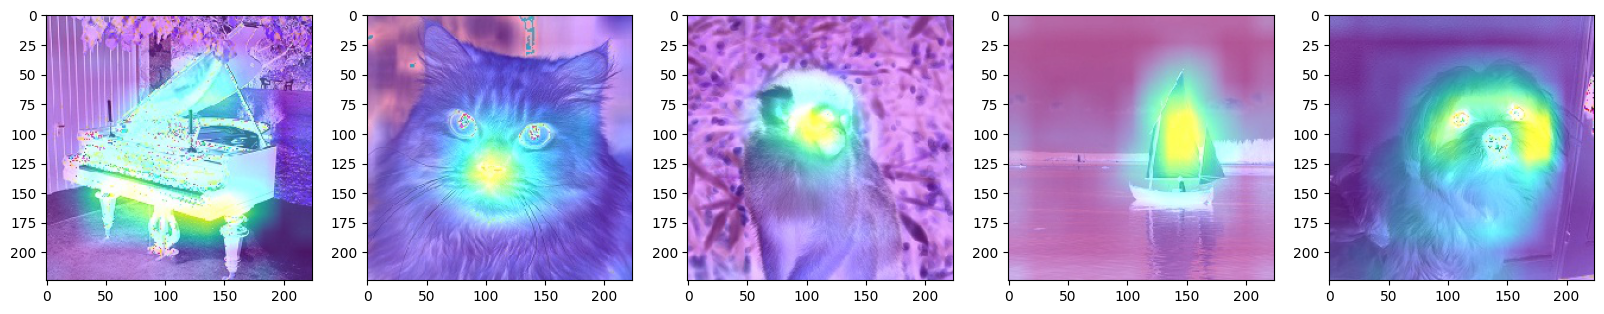

In [ ]:
# VGG16 로드
# 전이 학습 할 것이 아니기 때문에 include_top=True로 실행하려 모델의 마지막 부분까지 로드함
model = VGG16(weights="imagenet", include_top=True)
print([layer.name for layer in model.layers if "conv" in layer.name])

# 원본 이미지 이름과 Imagenet에서의 해당 이미지 인덱스
input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]

# 그레이디언트 CAM 알고리즘 선택
explainer = GradCAM()

# 그레이디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트
images_cams = []

# 그레이디언트 CAM 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img("./data/img/{}_0.jpg".format(l), target_size=(224, 224))  # 이미지를 불러오고 내부에서 처리될 이미지의 크기를 설정
    img = img_to_array(img)  # 이미지를 넘파이 배열로 바꾸어 줍니다.
    data = ([img], None)
    grid = explainer.explain(
        data, model, int(i), layer_name="block5_conv3"
    )  # 그레이디언트 CAM이 실행되는 부분, 마지막 출력 층을 찾지못해서 에러 발생 > layer_name="block5_conv3"을 명시적으로 지정해줘야 작동함
    explainer.save(grid, ".", "./data/img/{}_cam.jpg".format(l))

# 그레이디언트 CAM 알고리즘이 적용된 이미지를 불러오는 부분의 시작
plt.figure(figsize=(20, 20))

for img_path in glob.glob("./data/img/*_cam.jpg"):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

# Occluision

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


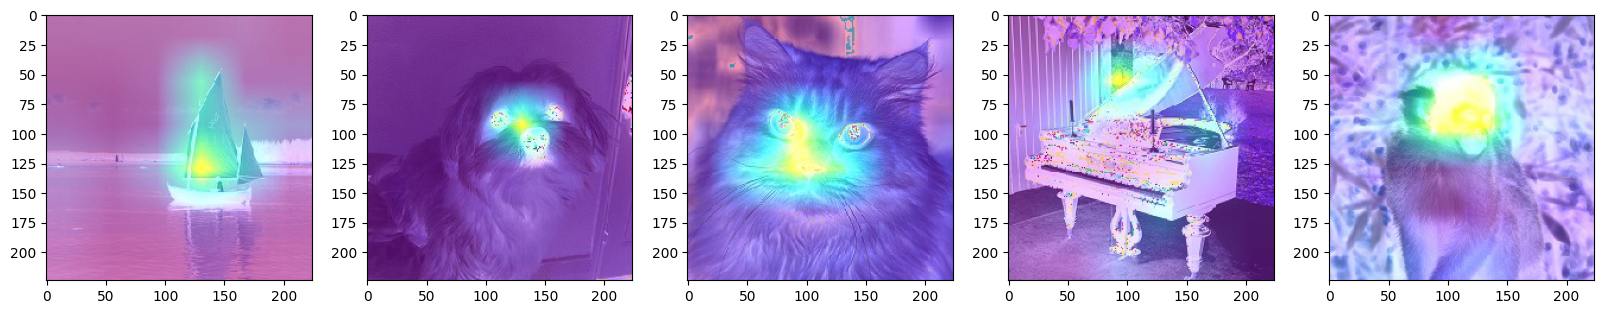

In [10]:
# 오클루전 알고리즘 정의
explainer = OcclusionSensitivity()

# 알고리즘이 적용된 이미지가 들어갈 리스트
images_occ1s = []

patch_size = 40

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img("./data/img/{}_0.jpg".format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size)  # 패치 사이즈의 설정
    explainer.save(grid, ".", "./data/img/{}_occ1.jpg".format(l))

# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작
plt.figure(figsize=(20, 20))

for img_path in glob.glob("./data/img/*_occ1.jpg"):
    images_occ1s.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step


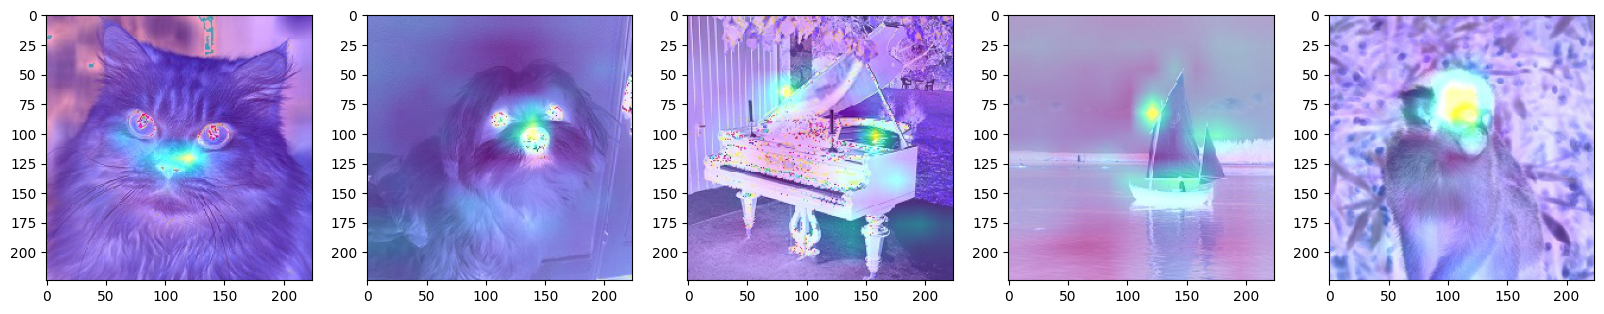

In [11]:
patch_size = 20

images_occ2s = []

for l, i in zip(input_list, imagenet_index):
    img = load_img("./data/img/{}_0.jpg".format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size)
    explainer.save(grid, ".", "./data/img/{}_occ2.jpg".format(l))

for img_path in glob.glob("./data/img/*_occ2.jpg"):
    images_occ2s.append(mpimg.imread(img_path))

plt.figure(figsize=(20, 20))
for i, image in enumerate(images_occ2s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

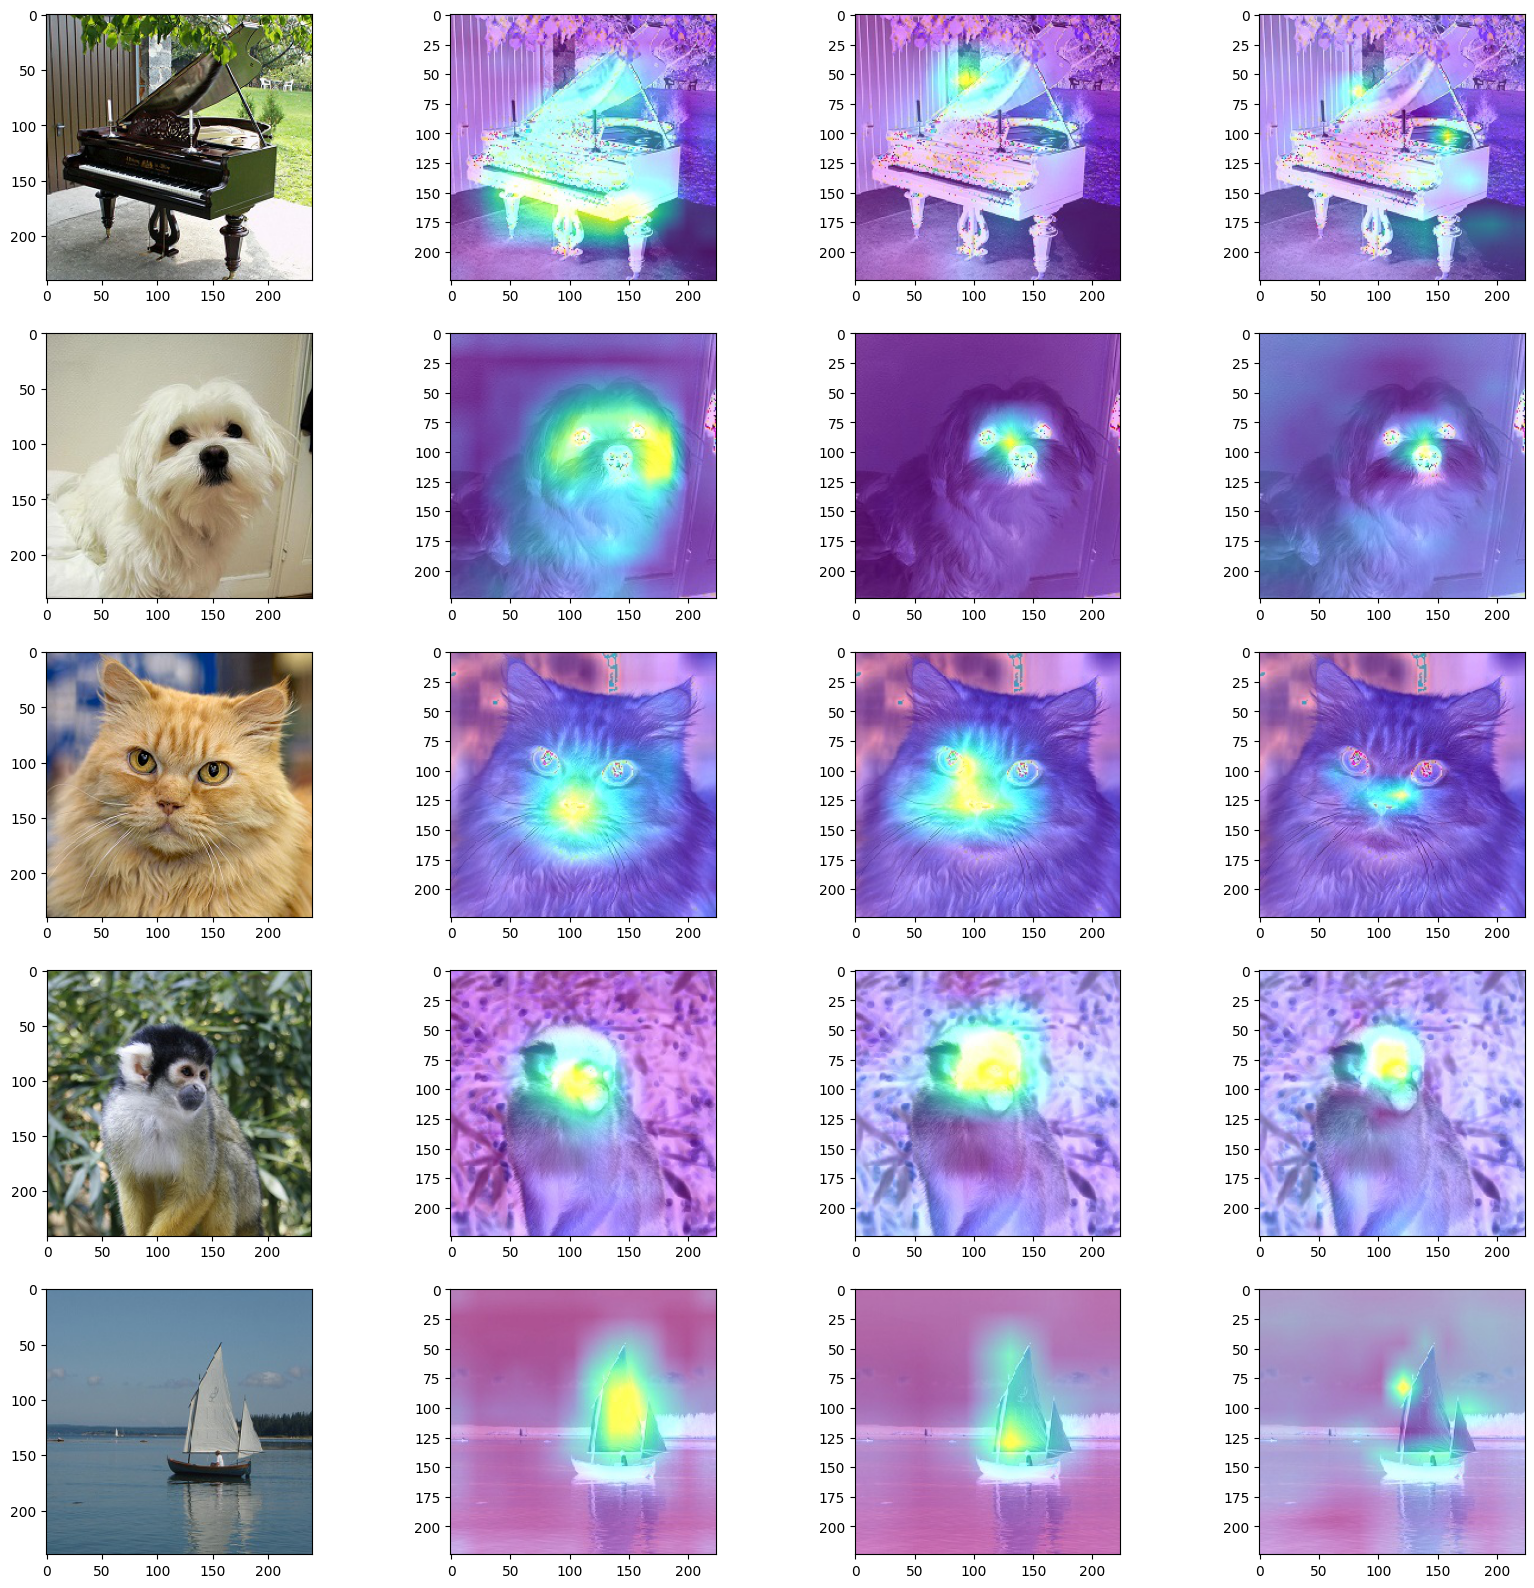

In [13]:
# 전체 이미지 한 눈에 보기.

plt.figure(figsize=(20, 20))

images = []
img_paths = sorted(glob.glob("./data/img/*.jpg"))
for img_path in img_paths:
    images.append(mpimg.imread(img_path))

for i, image in enumerate(images):
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)